# Ритейл — Анализ программы лояльности

Менеджер магазина строительных материалов "Строили, строили и наконец построили", отвечающий за программу лояльности клиентов, хочет оценить её эффективность. 
Цель проекта - на основе анализа программы лояльности магазина сформулировать предложения о повышении эффективности программы

### Описание данных:

Датасет содержит данные о покупках в магазине строительных материалов «Строили, строили и наконец построили». Все покупатели могут получить доступ в магазин с использованием персональных карт. За 200 рублей в месяц они могут стать участниками программы лояльности. В программу включены скидки, специальные предложения, подарки.

Презентация для менеджера - https://drive.google.com/file/d/1xwFWxEQ0OjF8MAk3oIqQ0v4tiZj1M7bo/view?usp=sharing

## План выполнения проекта

[Шаг 1. Загрузка и предобработка данных](#step1) 

- Проверка на дубликаты
- Обработка пропусков
- Переименовка столбцов
- Приведение данных к нужным типам
- Объединение таблиц и подсчёт общей суммы каждого чека

[Шаг 2. Исследовательский анализ данных](#step2)
 - Распределение количества наблюдений по времени
 - Клиенты без customer_id
 - Нулевое количество товаров в чеке
 - Значение C в purchase_id
 - Графики распределения признаков и удаление выбросов

[Шаг 3. Анализ программы лояльности](#step3)

- Графики количества уникальных покупателей в день, неделю и месяц с разбивкой на две категории (с и без программы лояльности)
- Графики среднего чека в день, неделю и месяц с разбивкой на две категории (с и без программы лояльности)
- Графики среднего размера корзины в день, неделю и месяц с разбивкой на две категории (с и без программы лояльности)
- Топ 10 самых часто продаваемых товаров с картой и без
- Магазины, в которых пользуются картой лояльности
- Количество возвратов с картой лояльности и без неё


[Шаг 4. Проверка статистических гипотез](#step4)

1. Нулевая гипотеза: средний чек с картой программы лояльности и без неё одинаков

   Альтернативная гипотеза: средний чек с картой лояльности отличается от среднего чека без неё
   
   
2. Нулевая гипотеза: среднее количество товаров в чеке с картой лояльности и без неё не отличается

   Альтернативная гипотеза: среднее количество товаров в чеке с картой лояльности и без неё будет разным

[Шаг 5. Выводы и рекомендации](#step5)

## <a id="step1">Шаг 1. Загрузка и предобработка данных </a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats as st
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
retail_dataset = pd.read_csv(r'L:\Data Analyst\12. Финальный проект/retail_dataset.csv')
retail_dataset.sample(3)

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
89743,544105,22386,9,2017-02-16 10:38:00,23246.0,Shop 0,1.0
64072,538524,22222,0,2016-12-13 09:35:00,NaN,Shop 0,0.0
41002,538349,22075,2,2016-12-10 14:59:00,NaN,Shop 0,0.0


In [3]:
retail_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


Таблица retail_dataset содержит следующие данные:
- *purchaseId* — id чека
- *item_ID* — id товара
- *purchasedate* — дата покупки
- *Quantity* — количество товара
- *CustomerID* — id покупателя
- *ShopID* — id магазина
- *loyalty_program* — участвует ли покупатель в программе лояльности

В таблице 105334 строки 7 столбцов, в столбце CustomerID есть пропуски.

In [4]:
product_codes = pd.read_csv(r'L:\Data Analyst\12. Финальный проект/product_codes.csv')
product_codes.sample(3)

,productID,price_per_one
1803,84459B,3.36
8887,21179,3.29
5155,22557,4.21


In [5]:
product_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


Таблица product_codes содержит 9969 строк и два столбца:
- *productID* — id товара
- *price_per_one* — стоимость одной единицы товара

In [6]:
#переименуем столбцы
retail_dataset.rename(columns={'purchaseid': 'purchase_id', 'item_ID': 'item_id', 'Quantity': 'quantity', 'purchasedate': 'purchase_time', 'CustomerID': 'customer_id', 'ShopID': 'shop_id'}, inplace=True)
product_codes.rename(columns={'productID': 'product_id'}, inplace=True)

In [7]:
#проверим на дубликаты
retail_dataset.duplicated().sum()

1033

In [8]:
#посмотрим на дубли повнимательнее, возьмем один для примера
retail_dataset[(retail_dataset['purchase_id'] == '537265') & (retail_dataset['item_id'] == '21499')]

,purchase_id,item_id,quantity,purchase_time,customer_id,shop_id,loyalty_program
1700,537265,21499,24,2016-12-06 11:26:00,21598.0,Shop 0,0.0
5345,537265,21499,24,2016-12-06 11:26:00,21598.0,Shop 0,0.0


А теперь вопрос: это дубликат в датасете или же покупатель сначала пробил в чек 24 единицы товара, а потом ещё раз 24 единицы того же товара? Например, если строительные перчатки лежат на прилавке в связке 24 пары, то как выставляется цена: за пару(т.е. связку можно разорвать) или за полный комплект (тогда quantity было бы 1)? Это можно уточнить у сотрудников магазина, а пока в рамках проекта предположим, что всё таки удобнее в подобных случаях продавать не поштучно, а значит это дубликаты, удалим их.

In [9]:
# удаляем дубликаты
retail_dataset = retail_dataset.drop_duplicates().reset_index(drop=True)

In [10]:
product_codes.duplicated().sum()

0

In [11]:
#проверим, можно ли заменить пропуски в customer_id по id чека
retail_dropna = retail_dataset.dropna().reset_index()
retail_na = retail_dataset[retail_dataset['customer_id'].isnull()].reset_index()
retail_na_new = retail_na.merge(retail_dropna,on='purchase_id',how='inner')
len(retail_na_new)

0

In [12]:
# раз пересечений нет, то может быть можно каждому клиенту без id присвоить уникальный номер
# посмотрим как часто клиенты приходили в магазин в зафиксированный в датасете период
retail_dropna.groupby('customer_id')['purchase_id'].nunique().reset_index()['purchase_id'].describe()

count    1749.000000
mean        2.370497
std         2.976829
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        46.000000
Name: purchase_id, dtype: float64

Больше четверти клиентов приходили в магазин чаще одного раза, а значит нельзя однозначно утверждать, что каждый чек без customer_id принадлежит уникальному клиенту. Ничего не остаётся, как заменить пропуски на нули.

In [13]:
retail_dataset = retail_dataset.fillna(0)

In [14]:
#изменим типы данных
retail_dataset['purchase_time'] = pd.to_datetime(retail_dataset['purchase_time'], format='%Y-%m-%d %H:%M:%S')
retail_dataset['customer_id'] = retail_dataset['customer_id'].astype('int64')
retail_dataset['loyalty_program'] = retail_dataset['loyalty_program'].astype('int64')

In [15]:
#создадим столбцы с датой, годом, месяцем и неделей
retail_dataset['purchase_year']  = retail_dataset['purchase_time'].dt.year
retail_dataset['purchase_month'] = retail_dataset['purchase_time'].dt.month
retail_dataset['purchase_week']  = retail_dataset['purchase_time'].dt.week
retail_dataset['purchase_date'] = retail_dataset['purchase_time'].dt.date

In [16]:
#посмотрим на столбец product_id
product_codes['product_id'].value_counts().head(10)

DOT       174
M          59
S          29
POST       15
D          13
79321      11
84406B     10
47566      10
82484       9
21673       9
Name: product_id, dtype: int64

In [17]:
# кажется для некоторых товаров есть несколько вариантов цен, посчитаем сколько таких товаров
prices_count = product_codes.groupby('product_id')['price_per_one'].nunique().reset_index()
prices_count[prices_count['price_per_one'] > 1].shape[0]

2494

In [18]:
# почти 2500 - это много. Заменим на медианное значение
product_codes = product_codes.pivot_table(index = 'product_id', values = 'price_per_one', aggfunc = 'median')

In [19]:
#добавим цены на товары к основному датасету
retail = retail_dataset.merge(product_codes, how='left', left_on='item_id', right_on='product_id')

In [20]:
#добавим столбец с выручкой
retail['revenue'] = retail['quantity'] * retail['price_per_one']
retail['loyalty_program'] = retail['loyalty_program'].replace({0: 'нет карты', 1: 'есть карта'})

In [21]:
# проверим, что получилось
retail.sample(3)

,purchase_id,item_id,quantity,purchase_time,customer_id,shop_id,loyalty_program,purchase_year,purchase_month,purchase_week,purchase_date,price_per_one,revenue
50300,541424,85059,3,2017-01-17 17:57:00,0,Shop 0,нет карты,2017,1,3,2017-01-17,3.555,10.665
30473,541265,21439,3,2017-01-16 16:23:00,23288,Shop 0,есть карта,2017,1,3,2017-01-16,2.460,7.380
82529,537434,21908,1,2016-12-06 16:57:00,0,Shop 0,нет карты,2016,12,49,2016-12-06,2.400,2.400


In [22]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 104301
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      104302 non-null  object        
 1   item_id          104302 non-null  object        
 2   quantity         104302 non-null  int64         
 3   purchase_time    104302 non-null  datetime64[ns]
 4   customer_id      104302 non-null  int64         
 5   shop_id          104302 non-null  object        
 6   loyalty_program  104302 non-null  object        
 7   purchase_year    104302 non-null  int64         
 8   purchase_month   104302 non-null  int64         
 9   purchase_week    104302 non-null  int64         
 10  purchase_date    104302 non-null  object        
 11  price_per_one    104302 non-null  float64       
 12  revenue          104302 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(5), object(5)
memory usage: 11.1+ 

### Вывод

В основном датасете были удалены дубликаты, пропуски в customer_id были заменены на 0. Во втором датасете product_codes цены были приведены к медианному значению. После чего оба датафрейма были объеденены в общий. Добавлены новые столбцы с выручкой, датой, годом, месяцем и неделей. Типы данных были изменены там, где это было необходимо. 

## <a id="step2">Шаг 2. Исследовательский анализ данных </a>

### Распределение количества наблюдений по времени

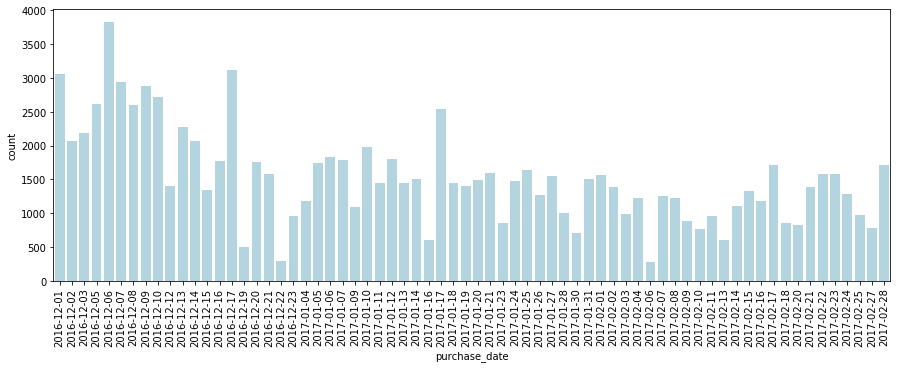

In [23]:
# посмотрим как распределены наблюдения по времени
plt.subplots(figsize=(15, 5))
f = sns.countplot(retail['purchase_date'].sort_values(), color = 'lightblue')
plt.xticks(rotation=90)
plt.show()

Посмотрим ещё на цены на товары.

In [24]:
#создадим список уникальных цен и посмотрим на распределение
pd.DataFrame(retail['price_per_one'].unique())[0].describe()

count     516.000000
mean       22.460775
std       295.623298
min         0.000000
25%         2.103750
50%         4.667500
75%         9.248750
max      6706.710000
Name: 0, dtype: float64

Наблюдения распределены по временной шкале примерно равномерно, делать срез данных за какой-то определенный адекватный период не требуется. На графике заметно, что в первой половине декабря 2016 в чеках было больше позиций, чем в 2017 году. По воскресеньям магазин не работает. В датасете отсутсвуют данные за период с 24 декабря 2016 по 3 января 2017. Возможно сеть закрывалась на праздники, но тогда это означало бы что, магазины находятся в Европе, где празднуют католическое рождество. В пользу такого предположения говорит ещё и тот факт, что цены в столбце price_per_one слишком маленькие, чтобы быть в рублях. В реальной жизни было бы необходимо уточнить у коллег, что происходило в эти даты, почему отсутсвуют данные.

### Клиенты без customer_id

Попробуем понять кто такие клиенты без customer_id, что они покупают и какой вклад вносят в общую выручку.

In [25]:
# посмотрим есть ли клиенты из программы лояльности без customer_id
retail.query('customer_id == 0')['loyalty_program'].value_counts()

нет карты    36148
Name: loyalty_program, dtype: int64

Все клиенты без customer_id не являются участниками программы лояльности. Логично.

In [26]:
#Посмотрим какой вклад в общую выручку вносят клиенты без customer_id
print(round(retail.query('customer_id == 0')['revenue'].sum() * 100 / retail['revenue'].sum(), 1), '%')

1.9 %


Всего 2% от общей выручки - это немного. Возможно они совершают небольшие покупки. Проверим.

In [27]:
retail.query('customer_id == 0').pivot_table(index = 'purchase_id', values = 'revenue', aggfunc = 'sum')['revenue'].describe()

count      748.000000
mean        51.993376
std       1962.500607
min     -13413.420000
25%        -15.353750
50%          0.000000
75%        113.028750
max      13119.430000
Name: revenue, dtype: float64

In [28]:
#удалим клиентов без номера персональной карты
retail = retail.query('customer_id != 0')

В условиях проекта сказано, что совершить покупку в магазине можно только предъявив персональную карту магазина. Остаётся неясным, что именно можно купить без неё. Чеки без карты бывают нулевыми, отрицательными, небольшими и многотысячными. Клиентов без customer_id было решено удалить из датасета, т.к. их вклад в общую выручку совсем небольшой.

### Нулевое количество товаров в чеке

In [29]:
print('{} % строк всего датасета имеют нулевое значение в столбце quantity'.format(round(retail[retail['quantity'] == 0].shape[0] * 100 / retail.shape[0])))

18 % строк всего датасета имеют нулевое значение в столбце quantity


Почему-то иногда в чек пробивается товар с нулевым количеством. Может быть это те самые подарки, которые обещают в программе лояльности.

In [30]:
retail[retail['quantity'] == 0]['loyalty_program'].value_counts()

нет карты     6896
есть карта    5586
Name: loyalty_program, dtype: int64

Товары с нулевым количеством появляются не только в чеках с картой лояльности. Может быть это и не подарки.

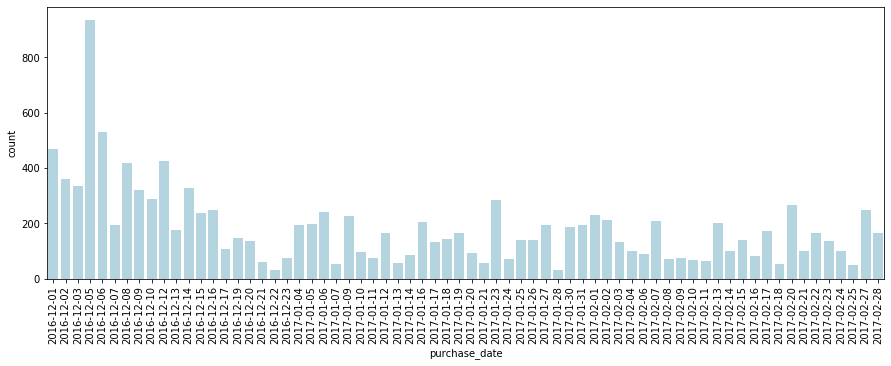

In [31]:
# посмотрим зависит ли нулевое значение в столбце quantity от времени
plt.subplots(figsize=(15, 5))
f = sns.countplot(retail[retail['quantity'] == 0]['purchase_date'].sort_values(), color = 'lightblue')
plt.xticks(rotation=90)
plt.show()

На сбой в системе не похоже, нулевые значения фиксировались на протяжении всего исследуемого периода. Хотя есть пик 5 декабря, может была какая-то промоакция.

In [32]:
# посомотрим зависит ли нулевое значение в столбце quantity от артикула товара
null_item_ids = retail[retail['quantity'] == 0]['item_id'].to_list()
null_item = retail.query('item_id in @ null_item_ids')

print('{} уникальных наименований товаров'.format(retail['item_id'].nunique()))
print('{} уникальных наименований товаров встречается с нулевым количеством'.format(null_item['item_id'].nunique()))
print('{} уникальных наименований товаров встречается только с нулевым количеством'.format(null_item.pivot_table(index='item_id', values='quantity', aggfunc='nunique').query('quantity == 1').shape[0]))

2776 уникальных наименований товаров
2107 уникальных наименований товаров встречается с нулевым количеством
173 уникальных наименований товаров встречается только с нулевым количеством


Остаётся непонятным, почему в некоторых случаях напротив товара в чеке стоит количество 0. Скорее всего это не зависит от артикула товара, т.к. из всех уникальных наименований товаров с нулевым количеством всего 8% товаров встречается только с 0. Нередки ситуации, когда артикул товара встречается в чеке как с нулевым, так и с ненулевым количествами. Может так странно оформляют в чеке акцию "n-ый товар в подарок". В любом случае остаётся только догадываться, что это за товары и почему они так странно пробиваются в чеке.

### Значение `C` в purchase_id

В столбце purchase_id есть чеки просто с числовым идентификатором, а есть чеки, в которых в начале присутсвует буква C. Возникло предположение, что это возвраты. "С" может означать cancel или correction. Проверим.

In [33]:
retail[retail['purchase_id'].str.contains('C')]['quantity'].describe()

count     1788.000000
mean       -56.061521
std       1768.890779
min     -74216.000000
25%         -7.000000
50%         -3.000000
75%         -2.000000
max         -2.000000
Name: quantity, dtype: float64

Все чеки с буквой С имеют отрицательное количество товаров.

In [34]:
#посмотрим сколько отрицательных чеков без буквы C
retail[(retail['quantity'] < 0) & (~retail['purchase_id'].str.contains('C'))].shape[0]

0

И все отрицательные чеки имеют букву С в начале. Посмотрим на пару примеров повнимательнее.

In [35]:
retail[(retail['item_id'] == "35957") & (retail['customer_id'] == 20590)]

,purchase_id,item_id,quantity,purchase_time,customer_id,shop_id,loyalty_program,purchase_year,purchase_month,purchase_week,purchase_date,price_per_one,revenue
2645,539320,35957,95,2016-12-16 19:16:00,20590,Shop 6,нет карты,2016,12,50,2016-12-16,0.42,39.90
101093,C539576,35957,-97,2016-12-20 12:25:00,20590,Shop 6,нет карты,2016,12,51,2016-12-20,0.42,-40.74


In [36]:
retail[(retail['item_id'] == "23166") & (retail['customer_id'] == 18025)]

,purchase_id,item_id,quantity,purchase_time,customer_id,shop_id,loyalty_program,purchase_year,purchase_month,purchase_week,purchase_date,price_per_one,revenue
49166,C541433,23166,-74216,2017-01-18 10:17:00,18025,Shop 0,нет карты,2017,1,3,2017-01-18,1.04,-77184.64
68612,541431,23166,74214,2017-01-18 10:01:00,18025,Shop 0,нет карты,2017,1,3,2017-01-18,1.04,77182.56


В обоих случаях вроде совпадают item_id и customer_id, отрицательный чек был позже положительного, но вот отрицательное quantity на 2 больше. Нельзя однозначно сказать, что это был возврат. К тому же для большинства отрицательных значений не удалось найти пару. Либо покупка была совершена раньше, чем даты выгрузки, либо теория с возвратами не верна. К тому же среди клиентов без customer_id есть небольшое количество отрицательных чеков без буквы С в начале (мы их отсеяли выше). Окончательно на данных ничего доказать не удалось. Предположим, однако, в рамках проекта, что отрицательные значения это всё же возварты и не будем их удалять, т.к. они влияют на выручку.

### Графики распределения признаков и удаление выбросов

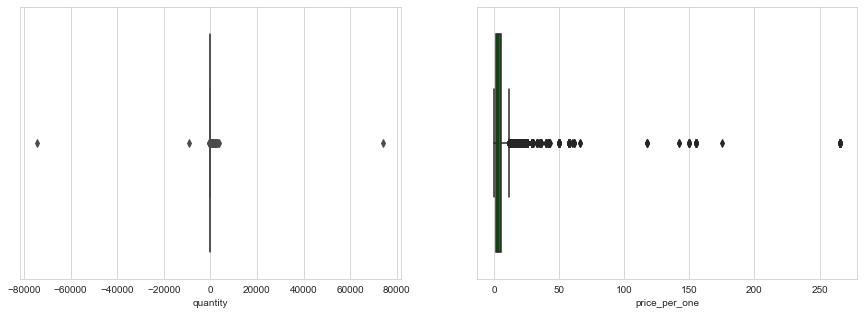

In [37]:
# попробуем посмотреть на распределение признаков количество и цена за штуку
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(retail['quantity'], color="r", ax=ax[0])
sns.boxplot(retail['price_per_one'], color="g", ax=ax[1])
plt.show()

Выбросы такие большие, на графике ничего не видно. Нужно от них избавится и построить новые.

In [38]:
# удалим выбросы по "усам ящика"
def remove_outliers(data, column):
    parametrs = data[column].describe().T
    q1_p = parametrs['25%']
    q3_p = parametrs['75%']
    iqr_p = q3_p - q1_p
    data = data[(data[column] < q3_p + 1.5*iqr_p) & (data[column] > q3_p - 1.5*iqr_p)]
    return data
for column in ['quantity', 'price_per_one']:
    retail = remove_outliers(retail, column)

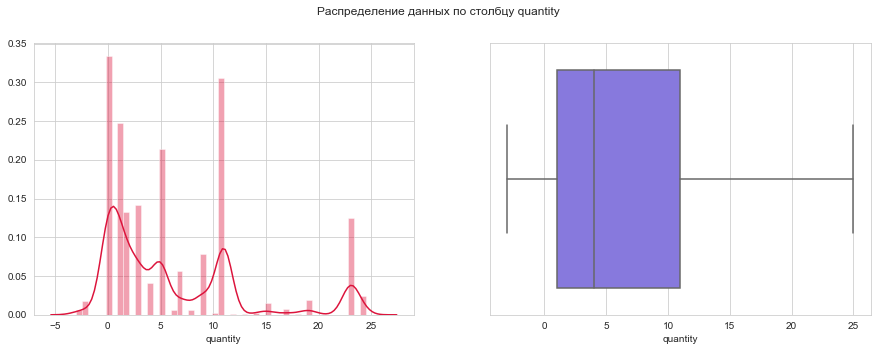

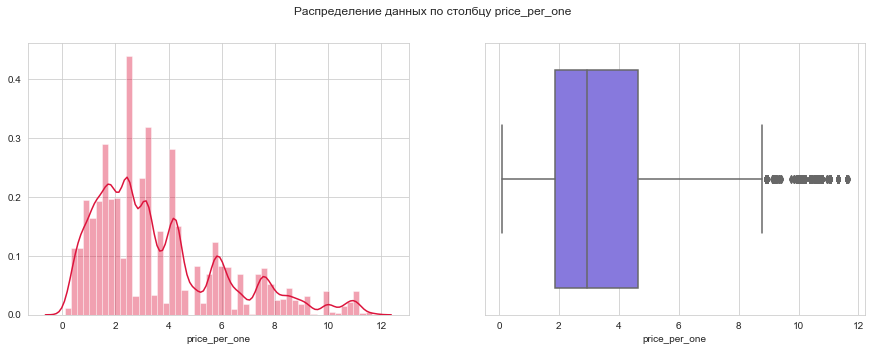

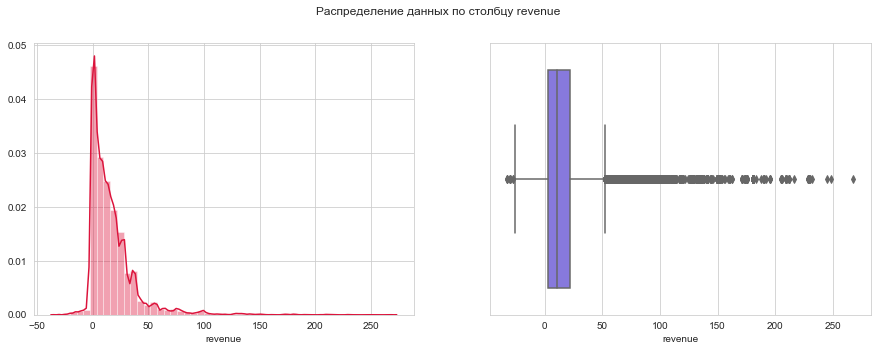

In [39]:
# Строим новые графики
for column in ['quantity', 'price_per_one', 'revenue']:
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Распределение данных по столбцу {}'.format(column))
    sns.distplot(retail[column], color="crimson", ax=ax[0])
    sns.boxplot(retail[column], color="mediumslateblue", ax=ax[1])
    plt.show()

После удаления выбросов и клиентов без customer_id датасет похудел почти на половину. С одной стороны это очень много, с другой стороны все эти огромные заказы были скорее всего оптовыми. Нас же в данном проекте интересует как ведут себя розничные покупатели. А клиенты без customer_id, ещё и с кучей нулевых позицией в чеке, только путали карты. При других целях исследования можно было бы выделить все огромные заказы в премиум сегмент и посмотреть на него отдельно.

In [40]:
# посмотрим на распределение наблюдений по магазинам
retail['shop_id'].value_counts()

Shop 0     52258
Shop 4      1405
Shop 1      1307
Shop 6       648
Shop 8       483
Shop 10      253
Shop 7       252
Shop 12      225
Shop 18      205
Shop 11      153
Shop 5       143
Shop 2       127
Shop 3       105
Shop 14       68
Shop 15       57
Shop 9        51
Shop 26       47
Shop 27       35
Shop 17       31
Shop 19       30
Shop 13       29
Shop 16       29
Shop 28       27
Shop 20       23
Shop 22       17
Shop 24       15
Shop 30       12
Shop 21       10
Shop 29        9
Name: shop_id, dtype: int64

Shop 0 явно самый крупный магазин сети, ему принадлежит 90% всех наблюдений в датасете. Это либо интернет магазин, либо оптовый склад. Исключим Shop 0 и на графике посмотрим как распределяются остальные наблюдения по магазинам.

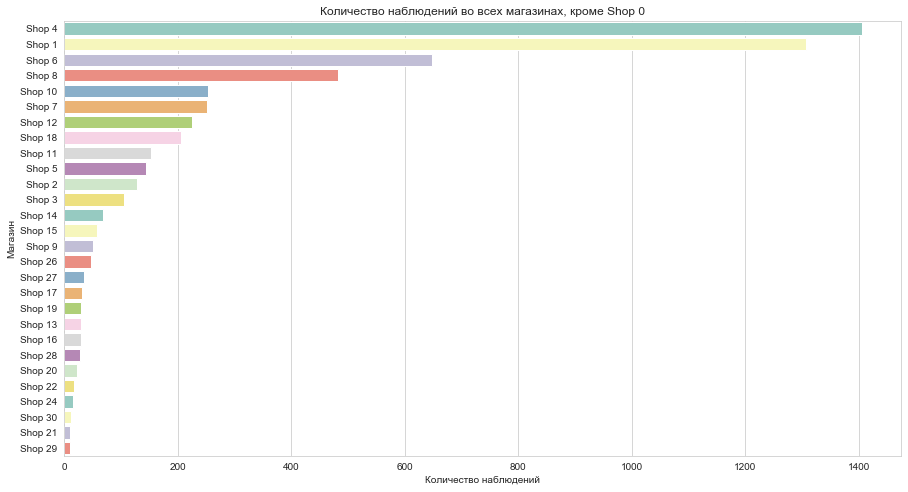

In [41]:
plt.figure(figsize=(15,8))
sns.countplot(y = 'shop_id', data =  retail.query('shop_id != "Shop 0"'), orient = "h", palette="Set3", order = retail.query('shop_id != "Shop 0"')['shop_id'].value_counts().index)
plt.title('Количество наблюдений во всех магазинах, кроме Shop 0')
plt.xlabel('Количество наблюдений')
plt.ylabel('Магазин')
plt.show()

В тройку лидеров входят магазины номер 4, 1 и 6. Есть 19 магазинов, где продали менее 100 позиций товаров за 3 месяца.

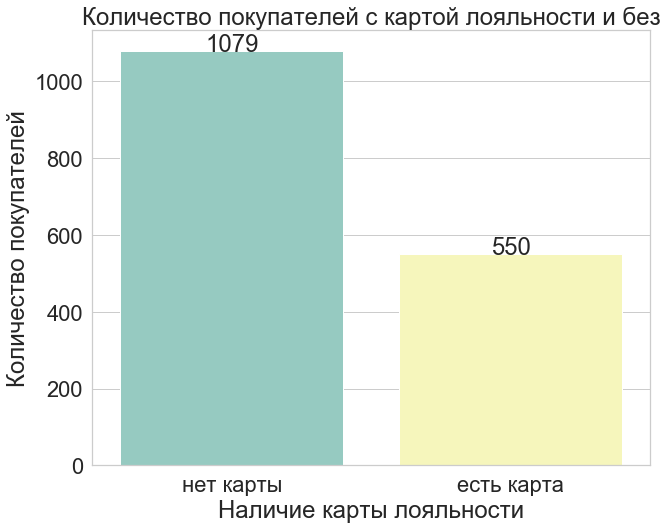

In [42]:
# посмотрим сколько клиентов магазинов пользуются картой лояльности
loyalty_program = retail.drop_duplicates(subset='customer_id')['loyalty_program'].value_counts().reset_index()
labels=loyalty_program['index'].value_counts().index
values=loyalty_program['loyalty_program'].value_counts().index
sns.set(style='whitegrid', font_scale=2)
plt.figure(figsize = (10, 8))
ax = sns.barplot(x=labels, y=values, palette="Set3")
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, values[i],ha="center")
plt.title('Количество покупателей с картой лояльности и без')
plt.xlabel('Наличие карты лояльности')
plt.ylabel('Количество покупателей')
plt.show()    

Клиентов с картой лояльности в два раза меньше, чем обычных покупателей.

### Вывод

- Магазин скорее всего находится в Европе, т.к. был закрыт с 24 декабря по 3 января и цены слишком маленькие, чтобы быть в рублях
- Клиенты без номера персональной карты (т.е. без customer_id) были удалены, т.к. они вносят слишком маленький вклад в целевую переменную
- Не удалось определить что означает нулевое количество товаров в чеке 
- Так же теория, что `С` означает возврат, не нашла однозначного подтверждения, но в рамках проекта счается всё же, что это именно возврат
- Аномально большие значения в столбцах quantity и price_per_one были удалены
- Shop 0 самый крупный магазин сети, ему принадлежит 90% всех наблюдений в датасете
- Клиентов с картой лояльности в два раза меньше, чем обычных покупателей

## <a id="step3">Шаг 3. Анализ программы лояльности </a>

### Графики количества уникальных покупателей в день, неделю и месяц с разбивкой на две категории (с и без программы лояльности)

In [43]:
# найдеём недостающие даты
missing_dates = pd.DataFrame(pd.date_range(start = '2016-12-01', end = '2017-02-28' ).difference(retail['purchase_date']))
missing_dates.columns = ['purchase_date']
# добавим столбец с программой лояльности
missing_dates['loyalty_program'] = np.nan
missing_dates['loyalty_program'] = missing_dates['loyalty_program'].fillna('есть карта,нет карты')
missing_dates = missing_dates.set_index('purchase_date').apply(lambda x: x.str.split(',').explode()).reset_index()
# добавим столбец с количеством чеков
missing_dates['customer_id'] = np.nan
missing_dates['customer_id'] = missing_dates['customer_id'].fillna(0)

# посчитаем количество уникальных покупателей в день
dau = retail.groupby(['purchase_date', 'loyalty_program']).agg({'customer_id': 'nunique'}).reset_index()
# добавим недостающие даты
dau_plot = pd.concat([dau, missing_dates])
dau_plot['purchase_date'] = pd.to_datetime(dau_plot['purchase_date'])

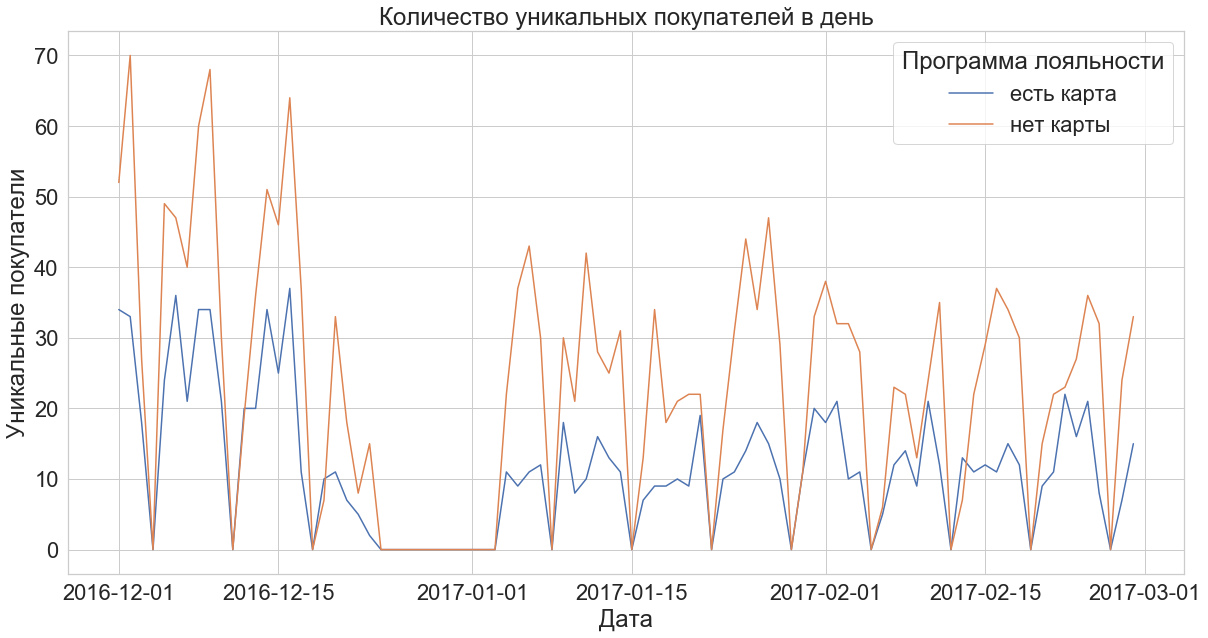

In [44]:
#посмотрим на количество уникальных покупателей в день
plt.subplots(figsize = (20, 10))
sns.lineplot(x='purchase_date', y='customer_id', hue = 'loyalty_program', data = dau_plot, legend=False)
plt.legend(title='Программа лояльности', loc='upper right', labels=['есть карта', 'нет карты'])
plt.title('Количество уникальных покупателей в день')
plt.ylabel('Уникальные покупатели')
plt.xlabel('Дата')
plt.show()

Из графика видно, что посетителей без карты лояльности регулярно больше. 2, 9 и 16 декабря были равномерные всплески активности в обеих группах (т.е. и с картой, и без). Возможно это связано с какой-нибудь предновогодней промоакцией. Рекорд в 70 уникальных покупателей в день был зафиксирован 2 декабря 2016 года в категории "без карты лояльности".

In [45]:
#посмотрим на количество уникальных покупателей в неделю
wau = retail.groupby(['purchase_year', 'purchase_week', 'loyalty_program']).agg({'customer_id': 'nunique'}).reset_index()
#добавим потерянную праздничную неделю
missing_week = pd.DataFrame([[52, 'есть карта', 2016, 0], [52, 'нет карты', 2016, 0]], columns = ["purchase_week", "loyalty_program", "purchase_year", "customer_id"])
wau = pd.concat([missing_week, wau])
#добавим столбец с неделей
wau['week_yr'] = pd.to_datetime(wau['purchase_year'].astype(str) + ' ' + wau['purchase_week'].astype(str) + ' 1',
                                format='%Y %U %w').astype('str')

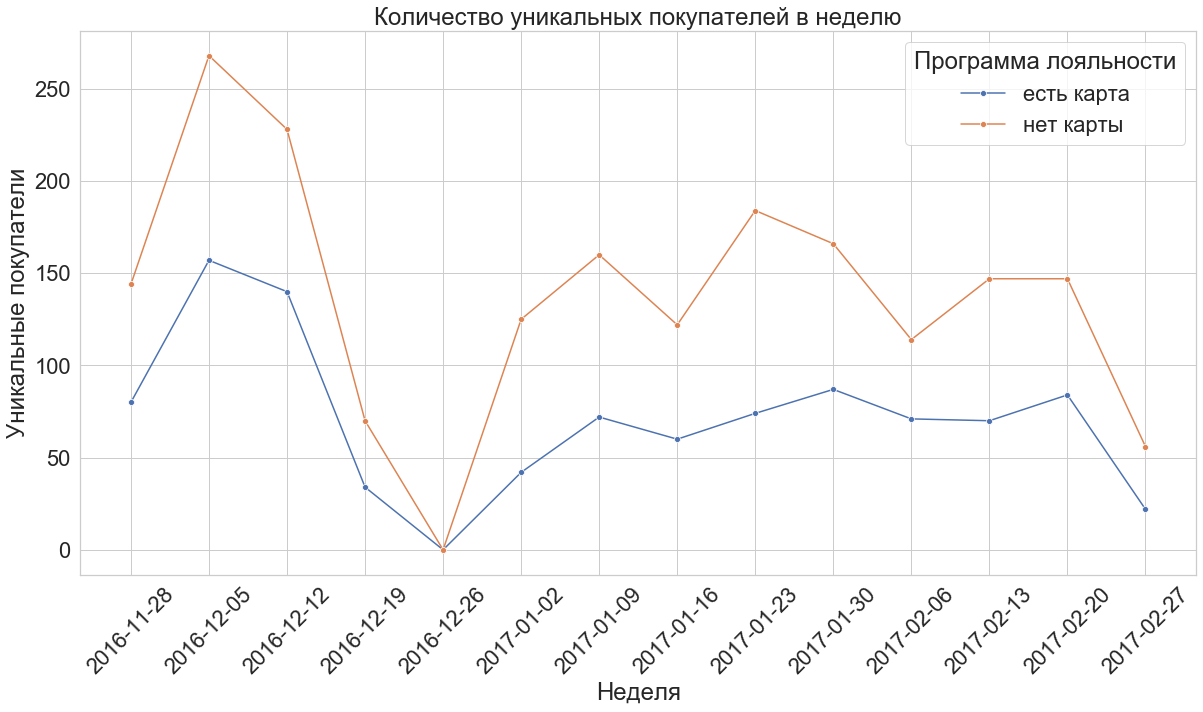

In [46]:
plt.subplots(figsize = (20, 10))
sns.lineplot(x='week_yr', y='customer_id', hue = 'loyalty_program', data = wau,  marker='o', legend=False)
plt.xticks(rotation=45)
plt.title('Количество уникальных покупателей в неделю')
plt.legend(title='Программа лояльности', loc='upper right', labels=['есть карта', 'нет карты'])
plt.ylabel('Уникальные покупатели')
plt.xlabel('Неделя')
plt.show()

На разбивке по неделям видно как снижается количество покупателей с середины декабря. Однако уже с начала января клиенты начинают появлятся достаточно часто.

In [47]:
#посмотрим на количество уникальных покупателей в месяц
mau = retail.groupby(['purchase_year', 'purchase_month', 'loyalty_program']).agg({'customer_id': 'nunique'}).reset_index()
mau['purchase_month'] = mau['purchase_month'].replace({12: 'декабрь', 1: 'январь', 2: 'февраль'})

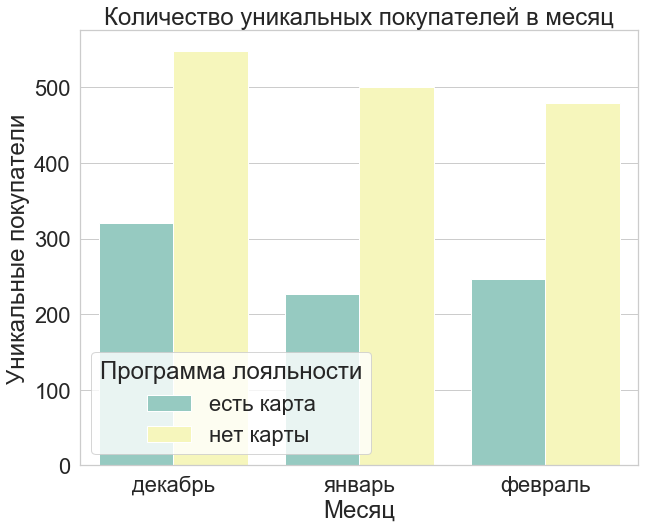

In [48]:
plt.subplots(figsize = (10, 8))
sns.barplot(x="purchase_month", y="customer_id", hue="loyalty_program", data=mau, palette="Set3")
plt.legend(title='Программа лояльности', loc='lower left')
plt.title('Количество уникальных покупателей в месяц')
plt.xlabel('Месяц')
plt.ylabel('Уникальные покупатели')
plt.show()

На разбивке по месяцам заметно, что количество уникальных пользователей без карты лояльности больше, чем с ней примерно в два раза. В декабре 2016 покупателей было больше всего в обеих группах. Возможно стройматериалы закупали не только частные клиенты, но и фирмы, которым было нужно освоить до конца года бюджет. 

### Графики среднего чека в день, неделю и месяц с разбивкой на две категории (с и без программы лояльности)

При подсчете среднего чека нужно учитывать, что клиенты с картой лояльности платят за неё 200 рублей в месяц согласно условиям проекта. В то же время анализ цен на товары показал, что скорее всего цены не в рублях, а магазин находится в Европе судя по датам праздников. Будет странно прибавлять 200 рублей к чекам в евро. Предположим, что стоимость участия в программе лояльности стоит примерно 3 евро.

In [49]:
#посчитаем средний чек и добавим его к основному датасету
check_sum = retail.pivot_table(index = 'purchase_id', values = 'revenue', aggfunc = 'sum')
retail = pd.merge(retail, check_sum, on = 'purchase_id', how='left')
retail.rename(columns={'revenue_x': 'revenue', 'revenue_y': 'check_sum'}, inplace=True)

In [50]:
#зададим стоимость участия в программе лояльности
loyalty_program_cost = 3

#посчитаем сколько нужно прибавить к каждому чеку за участие в программе лояльности
lp_costs = retail.query('loyalty_program == "есть карта"').groupby(['customer_id', 'purchase_month']).agg({'purchase_id': 'nunique'}).reset_index()
lp_costs['loy_fee'] = loyalty_program_cost / lp_costs['purchase_id']
#прибавим стоимость участия к сумме чека. Чтобы не плодить столбцы, прибавим сразу к основному столбцу с общей суммой чека
retail = pd.merge(retail, lp_costs, on=['customer_id', 'purchase_month'], how='left')
retail['loy_fee'] = retail['loy_fee'].fillna(0)
retail['check_sum'] = retail['loy_fee'] + retail['check_sum']
retail = retail.drop(columns=['purchase_id_y'])
retail.rename(columns={'purchase_id_x': 'purchase_id'}, inplace=True)

In [51]:
# посчитаем средний чек в день
average_check_per_day = retail.drop_duplicates(subset='purchase_id').groupby(['purchase_date', 'loyalty_program']).agg({'check_sum': 'median'}).reset_index()
# добавим недостающие даты
missing_dates['check_sum'] = np.nan
missing_dates['check_sum'] = missing_dates['check_sum'].fillna(0)
average_check = pd.concat([average_check_per_day, missing_dates])
average_check['purchase_date'] = pd.to_datetime(average_check['purchase_date'])

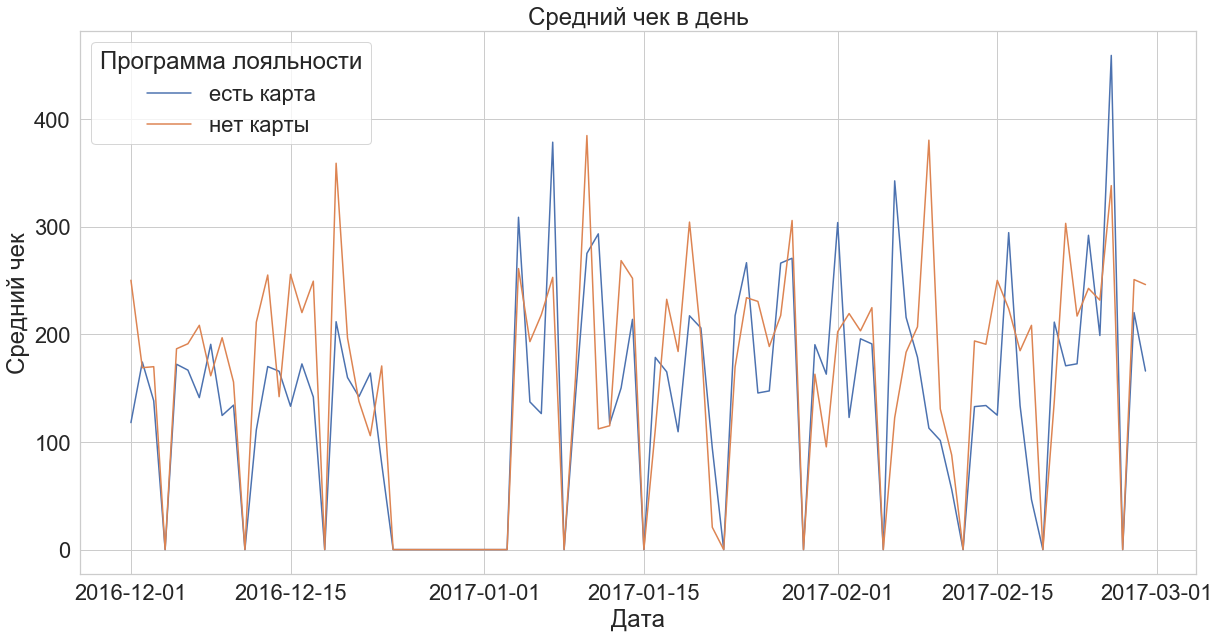

In [52]:
#посмотрим на средний чек в день
plt.subplots(figsize = (20, 10))
sns.lineplot(x='purchase_date', y='check_sum', hue = 'loyalty_program', data = average_check)
plt.legend(title='Программа лояльности', loc='upper left', labels=['есть карта', 'нет карты'])
plt.title('Средний чек в день')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.show()

График показывает, что средний чек без карты лояльности как правило выше, чем с ней в 2016 году. Но уже в 2017 году ситуация меняется и довольно часто клиенты из программы лояльности тратят больше. Нельзя однозначно сказать, что программа работает как задумано и стимулирует покупать больше. Нужны изменения.

In [53]:
#посмотрим на средний чек в неделю
average_check_per_week = retail.drop_duplicates(subset='purchase_id').groupby(['purchase_year', 'purchase_week', 'loyalty_program']).agg({'check_sum': 'median'}).reset_index()
#добавим потерянную праздничную неделю
missing_week = pd.DataFrame([[52, 'есть карта', 2016, 0], [52, 'нет карты', 2016, 0]], columns = ["purchase_week", "loyalty_program", "purchase_year", "check_sum"])
average_check_per_week = pd.concat([missing_week, average_check_per_week])
#добавим столбец с неделей
average_check_per_week['week_yr'] = pd.to_datetime(average_check_per_week['purchase_year'].astype(str) + ' ' + average_check_per_week['purchase_week'].astype(str) + ' 1',
                                format='%Y %U %w').astype('str')

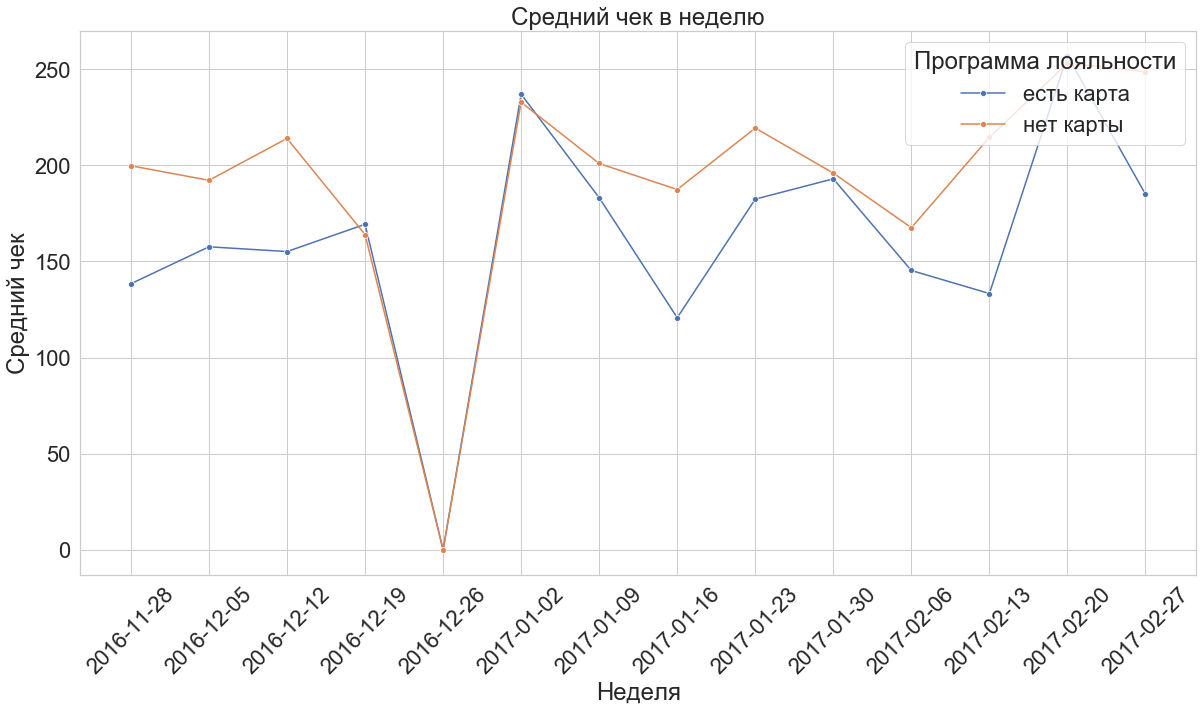

In [54]:
plt.subplots(figsize = (20, 10))
sns.lineplot(x='week_yr', y='check_sum', hue = 'loyalty_program', data = average_check_per_week,  marker='o')
plt.xticks(rotation=45)
plt.title('Средний чек в неделю')
plt.legend(title='Программа лояльности', loc='upper right', labels=['есть карта', 'нет карты'])
plt.ylabel('Средний чек')
plt.xlabel('Неделя')
plt.show()

В разбивке по неделям видно, что средний чек с программой лояльности не превышает средний чек без неё. Это плохой результат.

In [55]:
#посмотрим на средний чек в месяц
avg_check = retail.drop_duplicates(subset='purchase_id').groupby(['purchase_year', 'purchase_month', 'loyalty_program']).agg({'check_sum': 'median'}).reset_index()
avg_check['purchase_month'] = avg_check['purchase_month'].replace({12: 'декабрь', 1: 'январь', 2: 'февраль'})

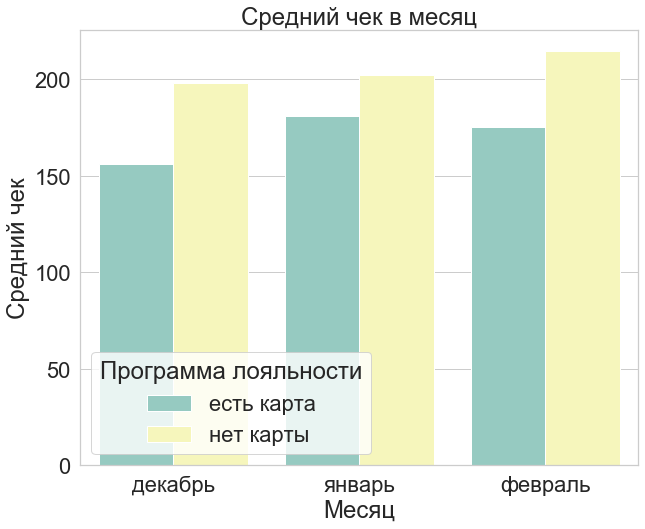

In [56]:
plt.subplots(figsize = (10, 8))
sns.barplot(x="purchase_month", y="check_sum", hue="loyalty_program", data=avg_check, palette="Set3")
plt.legend(title='Программа лояльности', loc='lower left')
plt.title('Средний чек в месяц')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.show()

На графике видно, что клиенты без карты лояльности тратят к сожалению больше, чем с ней.

Анализ среднего чека осложняется тем, что мы усреднили цены, то есть нет возможности учесть скидки, которые получают клиенты из программы лояльности, получается, что средний чек в программе лояльности должен быть ещё ниже.

### Графики среднего размера корзины в день, неделю, месяц с разбивкой на две категории (с и без программы лояльности)

In [57]:
#считаем количество товаров в чеке
basket_size = retail.pivot_table(index = 'purchase_id', values = 'quantity', aggfunc = 'sum')
retail = pd.merge(retail, basket_size, on = 'purchase_id', how='left')
retail.rename(columns={'quantity_x': 'quantity', 'quantity_y': 'basket_size'}, inplace=True)

In [58]:
# посчитаем средний размер корзины в день
average_basket_per_day = retail.drop_duplicates(subset='purchase_id').groupby(['purchase_date', 'loyalty_program']).agg({'basket_size': 'median'}).reset_index()
# добавим недостающие даты
missing_dates['basket_size'] = np.nan
missing_dates['basket_size'] = missing_dates['basket_size'].fillna(0)
average_basket_size = pd.concat([average_basket_per_day, missing_dates])
average_basket_size['purchase_date'] = pd.to_datetime(average_basket_size['purchase_date'])

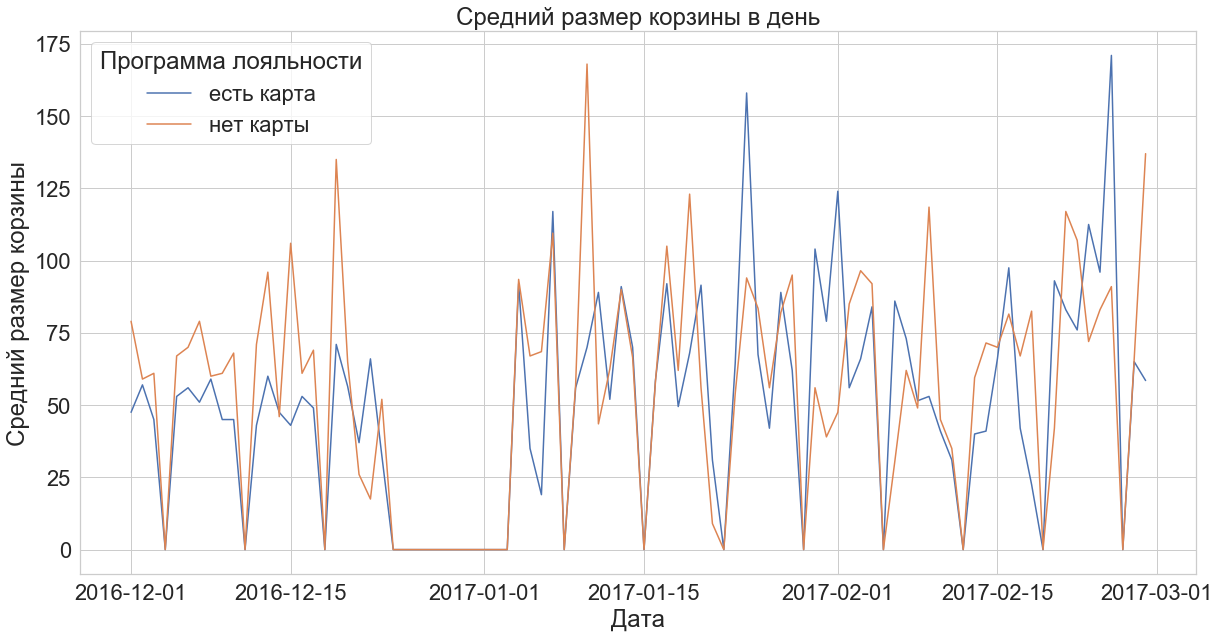

In [59]:
#посмотрим на средний размер корзины в день
plt.subplots(figsize = (20, 10))
sns.lineplot(x='purchase_date', y='basket_size', hue = 'loyalty_program', data = average_basket_size)
plt.legend(title='Программа лояльности', loc='upper left', labels=['есть карта', 'нет карты'])
plt.title('Средний размер корзины в день')
plt.ylabel('Cредний размер корзины')
plt.xlabel('Дата')
plt.show()

Количество товаров в корзине в 2016 году в среднем больше у покупателей без карты лояльности. В 2017 году ситуация меняется изо дня в день.

In [60]:
#посчитаем средний размер корзины в неделю
average_basket_per_week = retail.drop_duplicates(subset='purchase_id').groupby(['purchase_year', 'purchase_week', 'loyalty_program']).agg({'basket_size': 'median'}).reset_index()
#добавим потерянную праздничную неделю
missing_week = pd.DataFrame([[52, 'есть карта', 2016, 0], [52, 'нет карты', 2016, 0]], columns = ["purchase_week", "loyalty_program", "purchase_year", "basket_size"])
average_basket_per_week = pd.concat([missing_week, average_basket_per_week])
#добавим столбец с неделей
average_basket_per_week['week_yr'] = pd.to_datetime(average_basket_per_week['purchase_year'].astype(str) + ' ' + average_basket_per_week['purchase_week'].astype(str) + ' 1',
                                format='%Y %U %w').astype('str')

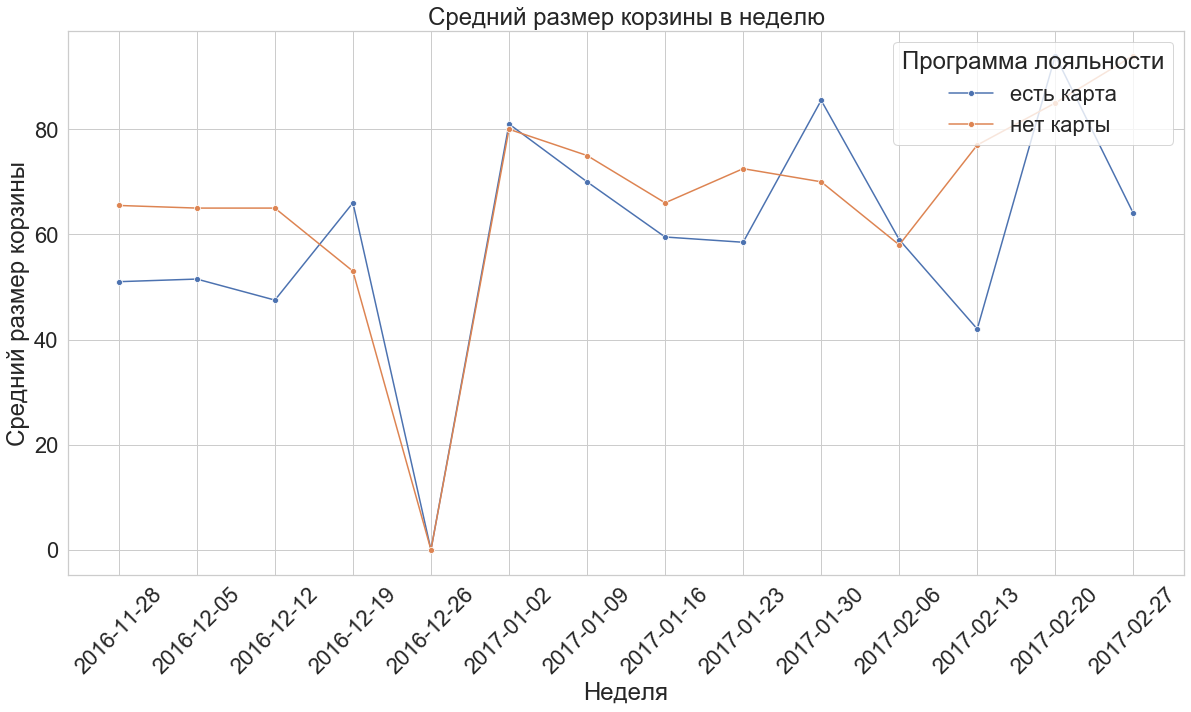

In [61]:
plt.subplots(figsize = (20, 10))
sns.lineplot(x='week_yr', y='basket_size', hue = 'loyalty_program', data = average_basket_per_week,  marker='o')
plt.xticks(rotation=45)
plt.title('Средний размер корзины в неделю')
plt.legend(title='Программа лояльности', loc='upper right', labels=['есть карта', 'нет карты'])
plt.ylabel('Средний размер корзины')
plt.xlabel('Неделя')
plt.show()

Среднее количество товаров в чеке в среднем больше у клиентов без карты лояльности. Видимо такие покупатели приходят в строительный магазин один раз, чтобы закупить всё для ремонта сразу. Клиенты с картой возвращаются в магазин по мере необходимости и покупает меньшее количество товаров под конкретный ремонт.

In [62]:
#посчитаем средний размер корзины в месяц
avg_basket_month = retail.drop_duplicates(subset='purchase_id').groupby(['purchase_year', 'purchase_month', 'loyalty_program']).agg({'basket_size': 'median'}).reset_index()
avg_basket_month['purchase_month'] = avg_basket_month['purchase_month'].replace({12: 'декабрь', 1: 'январь', 2: 'февраль'})

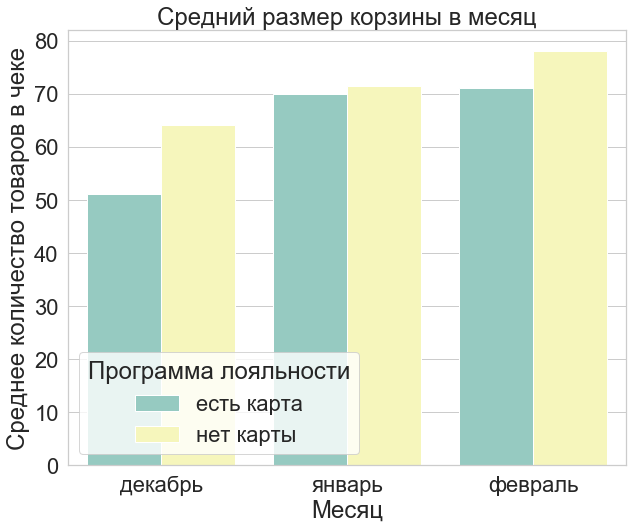

In [63]:
plt.subplots(figsize = (10, 8))
sns.barplot(x="purchase_month", y="basket_size", hue="loyalty_program", data=avg_basket_month, palette="Set3")
plt.legend(title='Программа лояльности', loc='lower left')
plt.title('Средний размер корзины в месяц')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество товаров в чеке')
plt.show()

В целом клиенты в обеих группах стали покупать больше единиц товара в 2017 году. Это хорошая тенденция.

### Топ 10 самых часто продаваемых товаров 

In [64]:
retail_lp_1 = retail.query('loyalty_program == "есть карта"').pivot_table(index='item_id', values='quantity', aggfunc='sum').sort_values('quantity', ascending=False).head(10)
retail_lp_0 = retail.query('loyalty_program == "нет карты"').pivot_table(index='item_id', values='quantity', aggfunc='sum').sort_values('quantity', ascending=False).head(10)
top_10 = pd.merge(retail_lp_1, retail_lp_0, how='outer', on='item_id')
top_10.columns = ['есть карта', 'нет карты']
top_10

,есть карта,нет карты
item_id,,
85123A,878.0,1325.0
84879,721.0,1210.0
22969,640.0,1214.0
22961,608.0,1718.0
21985,602.0,NaN
22469,598.0,1337.0
21212,540.0,2209.0
79321,512.0,NaN
85099B,505.0,1147.0


6 позиций из десяти в топах совпадают. Можно попробовать придумать промоакцию для этих товаров, чтобы больше клиентов без карты лояльности захотели приобрести её. Надо будет уточнить наценку.

### Магазины, в которых пользуются картой лояльности

In [65]:
retail.pivot_table(index='shop_id', values='purchase_id', columns='loyalty_program', aggfunc='nunique').sort_values('есть карта', ascending=False)

loyalty_program,есть карта,нет карты
shop_id,,
Shop 0,1161.0,1989.0
Shop 19,2.0,2.0
Shop 8,2.0,13.0
Shop 28,1.0,NaN
Shop 1,NaN,73.0
Shop 10,NaN,13.0
Shop 11,NaN,8.0
Shop 12,NaN,19.0
Shop 13,NaN,3.0


Картой лояльности пользуются только в Shop 0, самом крупном магазине сети. Всего 5 покупок за три месяца было совершено с картой лояльности в других магазинах.

### Количество возвратов с картой лояльности и без неё

In [66]:
retail.query('quantity < 0').pivot_table(index='loyalty_program', values='purchase_id', aggfunc='nunique')

,loyalty_program,purchase_id
loyalty_program,,
есть карта,1,115
нет карты,1,292


Клиенты из программы лояльности возвращают товары в 2.5 раза реже. Хоть в этом на них можно положиться.

### Вывод

- Уникальных покупателей с картой лояльности в среднем меньше, т.к. не все готовы платить 200 рублей (3 евро) в месяц за скидки и подарки
- Средний чек с картой лояльности ниже, даже несмотря на то, что в расчетах не учтены скидки по программе лояльности.
- Средний размер корзины колеблется также как и средний чек, но в целом больше у клиентов без карты лояльности
- Программой лояльности пользуются только в 4 магазинах
- Клиенты из программы лояльности возвращают товары в 2.5 раза реже

Программа лояльности не работает, не повышает средний чек, не стимулирует брать большее количество товаров. 

## <a id="step4">Шаг 4. Проверка статистических гипотез</a>

### Первая гипотеза

- Нулевая гипотеза: средний чек с картой программы лояльности и без неё одинаков

- Альтернативная гипотеза: средний чек с картой лояльности отличается от среднего чека без неё

In [67]:
# делаем срезы, считаем средний чек
loyalty_program_1 = (retail
                            .query('loyalty_program == "есть карта"')
                            .pivot_table(index = 'purchase_id', values = 'revenue', aggfunc = 'sum'))
loyalty_program_0 = (retail
                            .query('loyalty_program == "нет карты"')
                            .pivot_table(index = 'purchase_id', values = 'revenue', aggfunc = 'sum'))

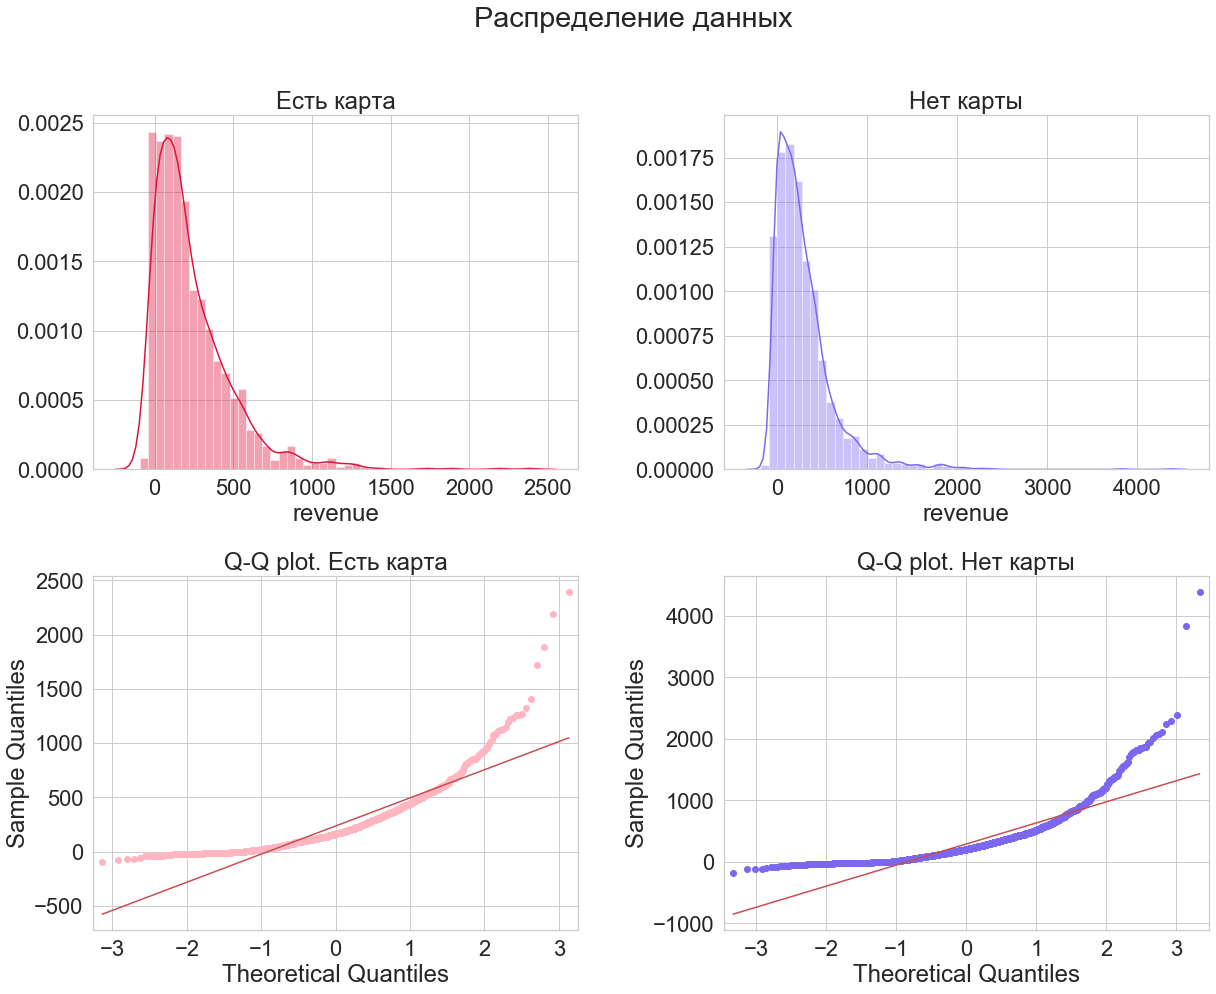

In [68]:
# проверяем данные на нормальность
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.subplots_adjust(wspace=0.3, hspace = 0.3)
fig.suptitle('Распределение данных')
sns.distplot(loyalty_program_1['revenue'], color="crimson", ax=ax[0, 0])
ax[0, 0].set_title('Есть карта')
sns.distplot(loyalty_program_0['revenue'], color="mediumslateblue", ax=ax[0, 1])
ax[0, 1].set_title('Нет карты')
sm.qqplot(loyalty_program_1['revenue'], line='s', color="lightpink", ax=ax[1, 0])
ax[1, 0].set_title('Q-Q plot. Есть карта')
sm.qqplot(loyalty_program_0['revenue'], line='s', color="mediumslateblue", ax=ax[1, 1])
ax[1, 1].set_title('Q-Q plot. Нет карты')
plt.show()

Так как у нас две назависимые выборки, а в данных есть выбросы, то для проверки наших гипотез, вместо t критерия Стьюдента мы будем пользоваться критерием Манна-Уитни. Логика данного критерия заключается в том, что вместо сравнения средних значений в двух выборках критерий сравнивает сумму рангов.

In [69]:
alpha = 0.05 

results = st.mannwhitneyu(
    loyalty_program_1['revenue'], 
    loyalty_program_0['revenue'],
    alternative='less')

print('p-value:', '{0:.6f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.000153
Отвергаем нулевую гипотезу


p value получилось таким маленьком, что при любом нам придется отвергнуть нулевую гипотезу и признать, что средний чек с картой лояльности и без значительно отличается. Это было видно на графиках выше.

### Вторая гипотеза

- Нулевая гипотеза: среднее количество товаров в чеке с картой лояльности и без неё не отличается
- Альтернативная гипотеза: среднее количество товаров в чеке с картой лояльности и без неё будет разным

In [70]:
#делаем срезы, считаем количество товаров в чеке
bundle_lp_1 = (retail
                    .query('loyalty_program == "есть карта"')
                    .pivot_table(index = 'purchase_id', values = 'quantity', aggfunc = 'sum'))
bundle_lp_0 = (retail
                    .query('loyalty_program == "нет карты"')
                    .pivot_table(index = 'purchase_id', values = 'quantity', aggfunc = 'sum'))

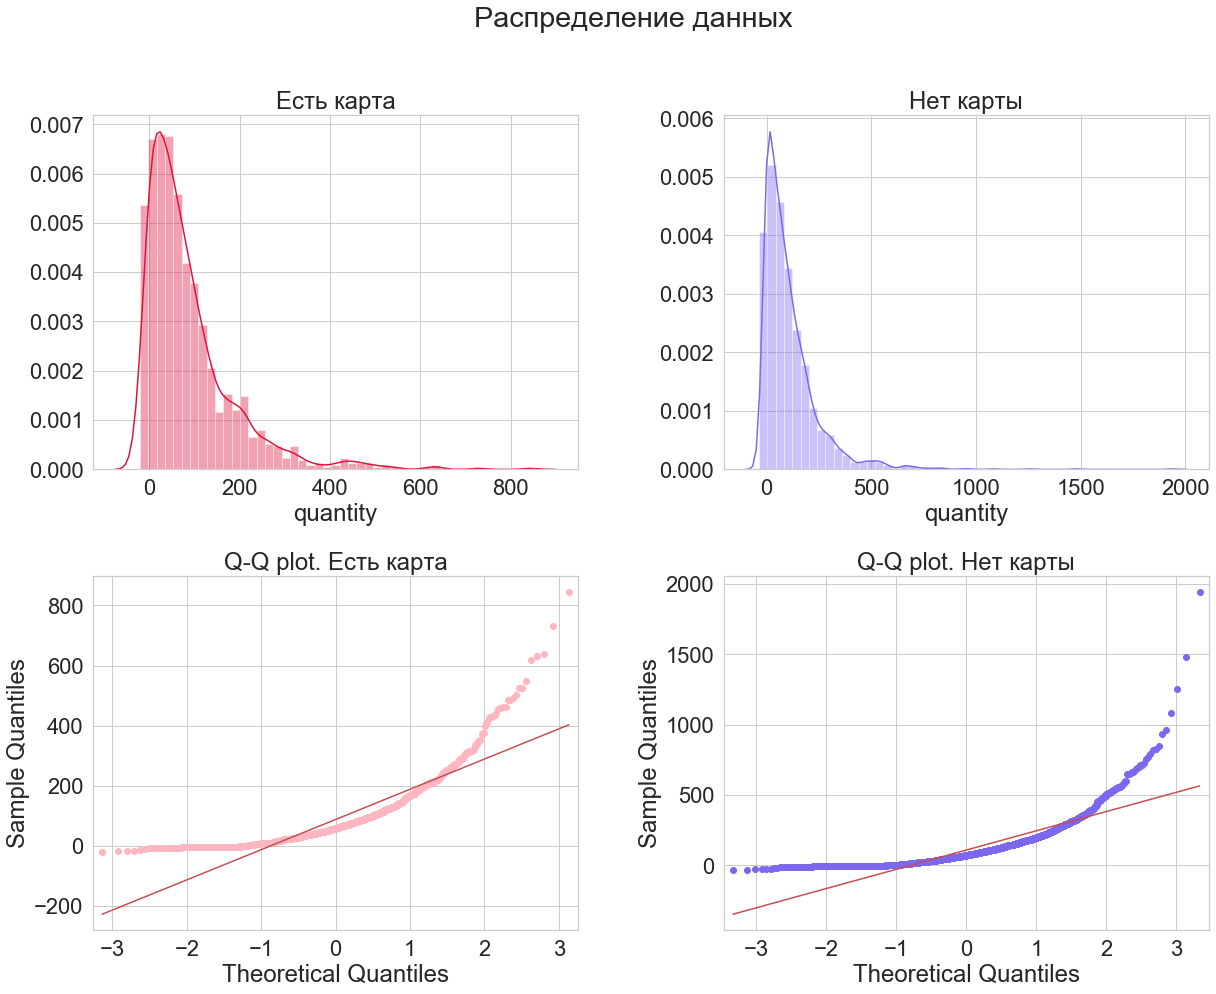

In [71]:
# проверяем данные на нормальность
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.subplots_adjust(wspace=0.3, hspace = 0.3)
fig.suptitle('Распределение данных')
sns.distplot(bundle_lp_1['quantity'], color="crimson", ax=ax[0, 0])
ax[0, 0].set_title('Есть карта')
sns.distplot(bundle_lp_0['quantity'], color="mediumslateblue", ax=ax[0, 1])
ax[0, 1].set_title('Нет карты')
sm.qqplot(bundle_lp_1['quantity'], line='s', color="lightpink", ax=ax[1, 0])
ax[1, 0].set_title('Q-Q plot. Есть карта')
sm.qqplot(bundle_lp_0['quantity'], line='s', color="mediumslateblue", ax=ax[1, 1])
ax[1, 1].set_title('Q-Q plot. Нет карты')
plt.show()

Так как у нас две назависимые выборки, а в данных опять есть значительные выбросы, то для проверки наших гипотез будем пользоваться критерием Манна-Уитни.

In [72]:
alpha = 0.05 

results = st.mannwhitneyu(
    bundle_lp_1['quantity'], 
    bundle_lp_0['quantity'],
    alternative='less')

print('p-value:', '{0:.6f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.001019
Отвергаем нулевую гипотезу


Опять же p value получилось слишком маленьким. Необходимо отвергнуть нулевую гипотезу. Количество товаров в чеке отличается в зависимости от факта наличия карты лояльности. Это тоже было видно на графиках.

## <a id="step5">Шаг 5. Вывод и рекомендации</a>

Вывод: 
- Карта лояльности не работает как задумано и не повышает средний чек
- Количество уникальных посетителей больше без карты
- Среднее количество товаров в чеке также больше без карты
- Картой лояльности пользуются только в самом крупном магазине Shop 0
- 6 видов товаров продаются весьма часто как с картой лояльности, так и без
    
Рекомендации:
- Необходимо пересмотреть условия программы лояльности
- Распространить программу лояльности на другие магазины сети. В данный момент участвует только 4.
- В продвижении карты лояльности попробовать сделать упор на популярные товары, которые хорошо продаются как с ней, так и без неё
- В чеках содержится довольно много бесплатных товаров, если это всё подарки, то нужно выяснить насколько это окупается
- Следует посмотреть данные за более продолжительный период, например за год, чтобы посчитать Retention Rate и LTV для клиентов с картой лояльности и без
- Возможно стоит отдельно изучить оптовые заказы и влияние карты лояльности на них